In [1]:
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer

from gensim import corpora
import gensim

from sklearn.metrics import f1_score

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import linear_sum_assignment

/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/umap/distanc

# Models

In [2]:
class Model:

    def __init__(self, dataset_name: str) -> None:
        self.dataset_name = dataset_name

        self.documents_df = pd.read_csv(f'../../datasets/data/{dataset_name}/documents.csv')
        self.documents_df = self.documents_df

        self.documents = self.documents_df['document'].tolist()
        self.labels = self.documents_df['class_name'].tolist()

        self.labels_df = pd.read_csv(f'../../datasets/data/{dataset_name}/labels.csv')
        self.defined_keywords = [keywords.split(' ') for keywords in self.labels_df['class_keywords'].tolist()]

        self.num_topics = len(set(self.labels))
        self.random_n_iter = 5
        self.limit_words_comparison = 1000

    def train(self) -> None:
        """ Train the model """
        raise NotImplementedError
    
    def get_words_for_topics(self, topics: list):
        """ Get the words for each topic from the documents

        Args:
            topics (list): The topics for each document

        Returns:
            dict: The words for each topic
        """
        words_by_topics = {}
        for idx, topic in enumerate(topics):
            words = self.documents_df.iloc[idx]['document'].split()

            if topic not in words_by_topics:
                words_by_topics[topic] = {}

            for word in words:
                if word not in words_by_topics[topic]:
                    words_by_topics[topic][word] = 0

                words_by_topics[topic][word] += 1

        # Transform the inner dicts into list sorted by the number of occurrences
        for topic in words_by_topics:
            words_by_topics[topic] = sorted(words_by_topics[topic].items(), key=lambda x: x[1], reverse=True)
            words_by_topics[topic] = [word for word in words_by_topics[topic]]
            words_by_topics[topic] = words_by_topics[topic][:self.limit_words_comparison]

        return words_by_topics
    
    def compute_similarity(self, true_words: list, extracted_words: list) -> float:
        """ Compute the similarity between two topics

        Args:
            true_words (list): The words of the true topic
            extracted_words (list): The words of the extracted topic

        Returns:
            float: The similarity between the two topics
        """
        similarity = 0
        total_count = 0

        for extracted_word, extracted_word_count in extracted_words:
            same_word_true_count = 0
            for true_word, true_word_count in true_words:
                if true_word == extracted_word:
                    same_word_true_count = true_word_count
                    break

            current_similarity = 1 - abs((extracted_word_count - same_word_true_count) / max(extracted_word_count, same_word_true_count))
            current_similarity *= (extracted_word_count + same_word_true_count)
            similarity += current_similarity

            total_count += extracted_word_count + same_word_true_count

        return similarity / total_count
    
    def compute_similarity_matrix(self, words_by_extracted_topics: dict, words_by_true_topics: dict) -> list:
        """ Compute the similarity matrix between each topic

        Args:
            words_by_extracted_topics (dict): The words for each extracted topic
            words_by_true_topics (dict): The words for each true topic

        Returns:
            list: The similarity matrix
        """
        similarity_matrix = []
        for _, extracted_topic in enumerate(words_by_extracted_topics):
            row = []
            for _, true_topic in enumerate(words_by_true_topics):
                row.append(self.compute_similarity(words_by_true_topics[true_topic], words_by_extracted_topics[extracted_topic]))
            similarity_matrix.append(row)

        return similarity_matrix
    
    def assign_topics(self, y_pred: list) -> dict:
        """ Assign extracted topics to true topics

        Args:
            y_pred (list): extracted topics

        Returns:
            dict: true topic associated to each extracted topic
        """
        words_by_extracted_topics = self.get_words_for_topics(y_pred)
        words_by_true_topics = self.get_words_for_topics(self.labels)

        similarity_matrix = self.compute_similarity_matrix(words_by_extracted_topics, words_by_true_topics)

        row_indices, col_indices = linear_sum_assignment(similarity_matrix, maximize=True)

        true_topic_labels = list(words_by_true_topics.keys())
        extracted_topic_labels = list(words_by_extracted_topics.keys())

        assignment = {}
        assignment_similarity = {}

        for extracted_topic_idx, true_topic_idx in zip(row_indices, col_indices):
            assignment[true_topic_labels[true_topic_idx]] = extracted_topic_labels[extracted_topic_idx]
            assignment_similarity[true_topic_labels[true_topic_idx]] = similarity_matrix[true_topic_idx][extracted_topic_idx]

        # -- Testing purpose: see the topic assignment with the words and similarity --
        # print('Global assignment similarity: ', sum(assignment_similarity.values()) / len(assignment_similarity.values()))

        # for idx, true_topic in enumerate(words_by_true_topics):
        #     print('Topic: ', true_topic)
        #     print('Assigned topic: ', assignment[true_topic])
        #     print('Similarity: ', assignment_similarity[true_topic])
        #     print('Extracted words: ', words_by_extracted_topics[assignment[true_topic]])
        #     print('True words: ', words_by_true_topics[true_topic])
        #     print('-------------------')

        return assignment
    
    def predict(self) -> list:
        """ Predict the topics for the train documents

        Returns:
            list: The predicted topics
        """
        raise NotImplementedError

    def get_f1_scores(self) -> float:
        """ Evaluate the model on the train documents
        
        Returns:
            list: f1 score values
        """
        raise NotImplementedError

In [3]:
class LDAModel(Model):

    def __init__(self, dataset_name: str) -> None:
        super().__init__(dataset_name)

    def train(self) -> None:
        """ See the documentation of the parent class """
        vectorizer = CountVectorizer()
        self.X = vectorizer.fit_transform(self.documents)

        self.model = LatentDirichletAllocation(n_components=self.num_topics, random_state=0)
        self.model.fit(self.X)

    def predict(self) -> list:
        """ See the documentation of the parent class """
        return self.model.transform(self.X).argmax(axis=1)
    
    def get_f1_scores(self) -> float:
        """ See the documentation of the parent class """
        f1_scores = []

        y_true = self.labels

        for i in range(self.random_n_iter):
            self.train()

            y_pred = self.predict()

            assignment = self.assign_topics(y_pred)
            assignment = {assignment[key]: key for key in assignment}
            y_pred = [assignment[topic] for topic in y_pred]

            f1_scores.append(f1_score(y_true, y_pred, average='macro'))

        return np.mean(f1_scores)

In [4]:
class BERTopicModel(Model):

    def __init__(self, dataset_name: str) -> None:
        super().__init__(dataset_name)

    def train(self) -> None:
        """ See the documentation of the parent class """
        umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=0)
        self.model = BERTopic(language="english", calculate_probabilities=True, nr_topics=self.num_topics, umap_model=umap)
        self.model.fit(self.documents)

    def predict(self) -> list:
        """ See the documentation of the parent class """
        return self.model.transform(self.documents)[0]
    
    def get_f1_scores(self) -> float:
        """ See the documentation of the parent class """
        f1_scores = []

        y_true = self.labels

        for i in range(self.random_n_iter):
            self.train()

            y_pred = self.predict()
            y_pred = [prediction + 1 for prediction in y_pred] # Consider the topic -1 as the topic 0

            assignment = self.assign_topics(y_pred)
            assignment = {assignment[key]: key for key in assignment}
            y_pred = [assignment[topic] for topic in y_pred]

            f1_scores.append(f1_score(y_true, y_pred, average='macro'))

        return np.mean(f1_scores)

In [5]:
class GuidedLDAModel(Model):

    def __init__(self, dataset_name: str) -> None:
        super().__init__(dataset_name)

    def train(self) -> None:
        """ See the documentation of the parent class """
        self.texts = [document.split(' ') for document in self.documents]
        
        self.dictionary = corpora.Dictionary(self.texts)
        self.corpus = [self.dictionary.doc2bow(text) for text in self.texts]

        priors = {}
        for idx, keywords in enumerate(self.defined_keywords):
            for keyword in keywords:
                priors[keyword] = idx

        eta = np.full(shape=(self.num_topics, len(self.dictionary)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
        for word, topic in priors.items(): # for each word in the list of priors
            keyindex = [index for index,term in self.dictionary.items() if term == word] # look up the word in the dictionary
            if (len(keyindex) > 0): # if it's in the dictionary
                eta[topic,keyindex[0]] = 1e7  # put a large number in there
        eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics

        with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
            self.model = gensim.models.ldamodel.LdaModel(
                corpus=self.corpus, id2word=self.dictionary, num_topics=self.num_topics,
                random_state=42, chunksize=100, eta=eta,
                eval_every=-1, update_every=1,
                passes=150, alpha='auto', per_word_topics=True)

    def predict(self) -> list:
        """ See the documentation of the parent class """
        scores = [[value[1] for value in score_values[0]] for score_values in self.model[self.corpus]]
        return [np.argmax(score) for score in scores]
    
    def get_f1_scores(self) -> float:
        """ See the documentation of the parent class """
        f1_scores = []

        y_true = self.labels

        for i in range(self.random_n_iter):
            self.train()

            y_pred = self.predict()

            assignment = self.assign_topics(y_pred)
            assignment = {assignment[key]: key for key in assignment}
            y_pred = [assignment[topic] for topic in y_pred]

            f1_scores.append(f1_score(y_true, y_pred, average='macro'))

        return np.mean(f1_scores)

In [6]:
class GuidedBERTopicModel(BERTopicModel):

    def __init__(self, dataset_name: str) -> None:
        super().__init__(dataset_name)

    def train(self) -> None:
        """ See the documentation of the parent class """
        umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=0)
        self.model = BERTopic(language="english", calculate_probabilities=True, nr_topics=self.num_topics, umap_model=umap, seed_topic_list=self.defined_keywords)
        self.model.fit(self.documents)

# Assignment example

In [7]:
def get_embeddings_df_for_model(model: Model):
    """ Get the embeddings dataframe for a model
    
    Args:
        model (Model): The model to use

    Returns:
        pd.DataFrame: The embeddings dataframe
    """
    embeddings_df = pd.DataFrame()
    embeddings_df['document'] = model.documents

    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = embedding_model.encode(model.documents)

    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(embeddings)

    embeddings_df['embedding_1'] = embeddings[:, 0]
    embeddings_df['embedding_2'] = embeddings[:, 1]

    model_predictions = model.predict()
    assignments = model.assign_topics(model_predictions)
    assignments = {assignments[key]: key for key in assignments}

    embeddings_df['y_true'] = model.labels
    embeddings_df['y_pred'] = [assignments[topic] for topic in model_predictions]
    
    return embeddings_df, assignments

In [8]:
def plot_assignment_example_for_model(model_name: str, embeddings_df: pd.DataFrame, assignments: dict) -> None:
    """ Plot the assignment example for a model
    
    Args:
        model_name (str): The name of the model
        embeddings_df (pd.DataFrame): The embeddings dataframe
        assignments (dict): The assignments
    """
    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    fig.suptitle(f'Assignment example - {model_name}', fontsize=20, fontweight='bold')

    x, y = 0, 0
    inverse_assignments = {assignments[key]: key for key in assignments}

    for class_idx, class_name in enumerate(set(embeddings_df['y_true'])):
        true_class_embeddings = embeddings_df[embeddings_df['y_true'] == class_name]
        extracted_class_embeddings = embeddings_df[embeddings_df['y_pred'] == class_name]

        sns.kdeplot(data=true_class_embeddings, x='embedding_1', y='embedding_2', ax=ax[x, y], shade=True, alpha=0.5, label='True class', color=sns.color_palette('viridis', n_colors=2)[0])
        sns.kdeplot(data=extracted_class_embeddings, x='embedding_1', y='embedding_2', ax=ax[x, y], shade=True, alpha=0.5, label='Assigned class', color=sns.color_palette('viridis', n_colors=2)[1])

        sns.scatterplot(data=true_class_embeddings, x='embedding_1', y='embedding_2', ax=ax[x, y], label='True class', color=sns.color_palette('viridis', n_colors=2)[0])
        sns.scatterplot(data=extracted_class_embeddings, x='embedding_1', y='embedding_2', ax=ax[x, y], label='Assigned class', color=sns.color_palette('viridis', n_colors=2)[1])

        title = 'True class: ' + class_name + ' | Assigned class: ' + str(inverse_assignments[class_name])
        ax[x, y].set_title(title, fontsize=14, fontweight='bold')
        ax[x, y].legend()

        y += 1
        if y == 2:
            x += 1
            y = 0

    ax[2, 1].axis('off')
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(f'../../figures/tm_defined_classes/assignment_example_{model_name.lower()}.png')

In [9]:
# lda_model = LDAModel('BBC_News')
# lda_model.train()

In [10]:
# lda_embeddings_df, lda_assignments = get_embeddings_df_for_model(lda_model)

In [11]:
# plot_assignment_example_for_model('LDA', lda_embeddings_df, lda_assignments)

In [12]:
# bert_model = BERTopicModel('BBC_News')
# bert_model.train()

In [13]:
# bert_embeddings_df, bert_assignments = get_embeddings_df_for_model(bert_model)

In [14]:
# plot_assignment_example_for_model('BERTopic', bert_embeddings_df, bert_assignments)

# Evaluation

In [15]:
def get_f1_scores_by_datasets(models: dict, datasets_names: list):
    """ Compute the f1 scores for each dataset and each model

    Args:
        models (dict): The models to evaluate
        datasets_names (list): The names of the datasets

    Returns:
        dict: The f1 scores for each dataset and each model
    """
    f1_scores_by_datasets = {}
    for dataset_name in datasets_names:
        f1_scores_by_datasets[dataset_name] = {}

        for model_name in models:
            model = models[model_name](dataset_name)
            f1_scores_by_datasets[dataset_name][model_name] = model.get_f1_scores()

    return f1_scores_by_datasets

In [16]:
predefined_scores = {
    'BBC_News': {
        'Random': 0.2,
        'Lbl2Vec': 0.61,
    },
    '20NewsGroup': {
        'Random': 0.05,
        'Lbl2Vec': 0.16,
    },
    'DBLP': {
        'Random': 0.25,
        'Lbl2Vec': 0.55,
    },
    'M10': {
        'Random': 0.1,
        'Lbl2Vec': 0.28,
    },
}

In [23]:
def get_and_save_result_for_dataset(dataset_name, models, load: bool = False):
    """ Get and save the results for a dataset
    
    Args:
        dataset_name (str): The name of the dataset
        models (dict): The models to evaluate
        load (bool, optional): Whether to load the results or not. Defaults to False.
        
    Returns:
        pd.DataFrame: The results dataframe
    """
    if load:
        results_df = pd.read_csv(f'./results/{dataset_name.lower()}.csv', index_col=0)
        return results_df

    f1_scores_by_datasets = get_f1_scores_by_datasets(models, [dataset_name])

    complete_f1_scores_by_datasets = {}
    for dataset_name in f1_scores_by_datasets:
        complete_f1_scores_by_datasets[dataset_name] = predefined_scores[dataset_name]
        complete_f1_scores_by_datasets[dataset_name].update(f1_scores_by_datasets[dataset_name])
    
    results_df = pd.DataFrame(complete_f1_scores_by_datasets)
    results_df['Model'] = results_df.index
    results_df.rename(columns={dataset_name: 'F1 score'}, inplace=True)
    results_df.reset_index(drop=True, inplace=True)

    results_df.to_csv(f'./results/{dataset_name.lower()}.csv')

    return results_df

In [24]:
models = {
    'LDA': LDAModel,
    'BERTopic': BERTopicModel,
    'GuidedLDA': GuidedLDAModel,
    'GuidedBERTopic': GuidedBERTopicModel,
}

In [25]:
bbc_news_result_df = get_and_save_result_for_dataset('BBC_News', models, load=True)

In [28]:
twenty_news_group_result_df = get_and_save_result_for_dataset('20NewsGroup', models, load=True)

In [ ]:
dblp_result_df = get_and_save_result_for_dataset('DBLP', models, load=False)

In [ ]:
m10_result_df = get_and_save_result_for_dataset('M10', models, load=False)

# Plot

In [62]:
def plot_for_results_dfs(results_dfs: list):
    """ Plot for a list of results dataframes
    
    Args:
        results_dfs (list): The results dataframes
    """
    colors = sns.color_palette('viridis', n_colors=len(results_dfs[0][1]))

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f'F1 scores by datasets', fontsize=20, fontweight='bold')

    x, y = 0, 0

    for dataset_name, results_df in results_dfs:
        sns.barplot(data=results_df, x='Model', y='F1 score', ax=ax[x, y], palette=colors)
        ax[x, y].set_title(dataset_name, fontsize=14, fontweight='bold')

        y += 1
        if y == 2:
            x += 1
            y = 0

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(f'../../figures/tm_defined_classes/f1_scores_by_datasets.png')

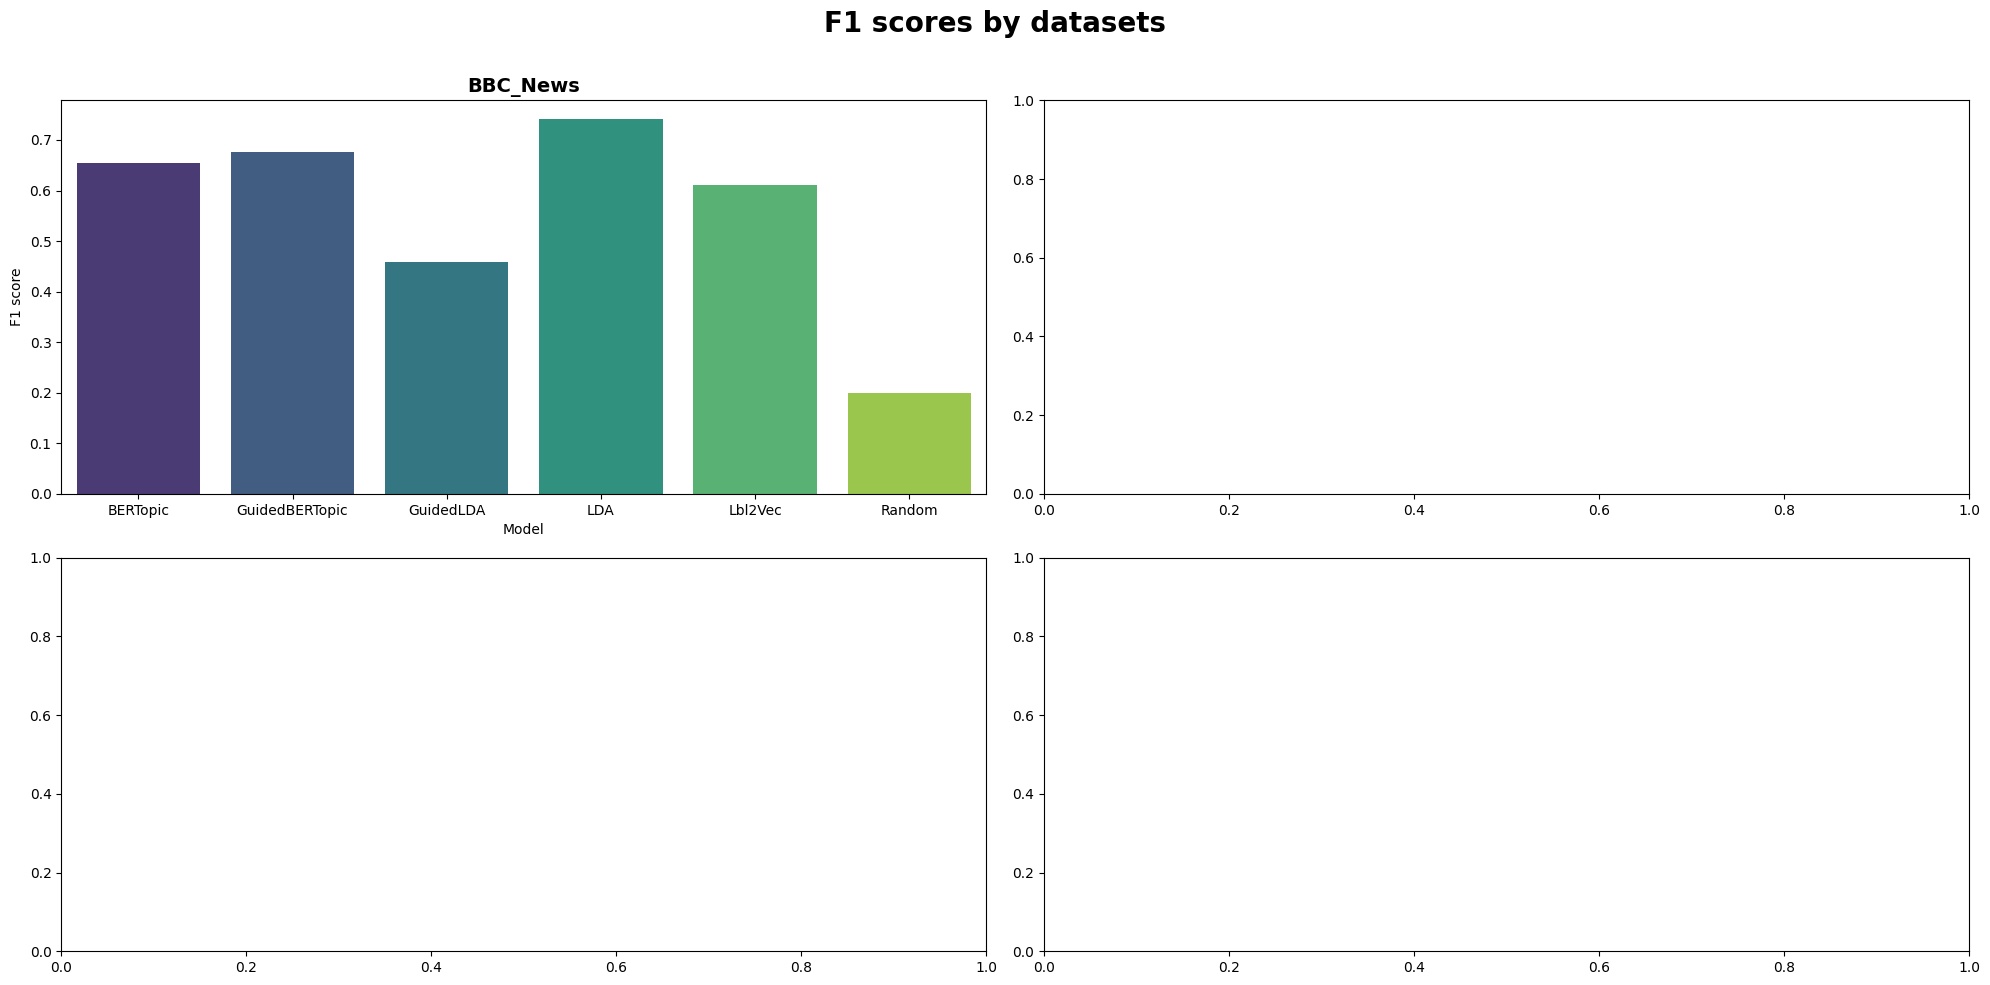

In [63]:
plot_for_results_dfs([
    ('BBC_News', bbc_news_result_df),
    # ('20NewsGroup', twenty_news_group_result_df),
    # ('DBLP', dblp_result_df),
    # ('M10', m10_result_df),
])